Breast Cancer Analysis and Prediction
Recall = 1. Precision = .92 Accuracy = .971

Vincent Lugat

September 2018

1. Load libraries and read the data
1.1. Load libraries
1.2. Read the data
1.3. Missing values
1.4. Reassign target and drop useless features
2. Exploratory Data Analysis (EDA)
2.1. Head and describe
2.2. Target distribution (number and %)
2.3. Features distribution (hue = diagnosis)
2.4. Correlation matrix
2.5. Positive correlated features
2.6. Uncorrelated features
2.7. Negative correlated features
4. Define functions
4.1. Confusion matrix and show metrics
4.2. Precision – Recall curve
4.3. ROC curve
4.4. Learning curve
4.5. Cross validation metrics
5. Prepare dataset
5.1. Define (X, y)
5.2. Standard scaler (X)
5.3. Train test split
6. Predictive model : Logistic Regression
6.1. Logistic Regression and GridSearch CV to optimise hyperparameters (accuracy)
6.2. RFE : Recursive features elimination (30 features => 15 features)
6.3. Compare learning curves and cross validation scores
6.4. Select threshold for a recall = 100% (all malignant tumors detected)
6.5. Predicting with recall = 100%
7. Predictive model 2 : Ensemble Classifier to maximise precision and detect all malignant tumors
7.1. Logistic Regression and GridSearch CV to optimise hyperparameters (recall)
7
7.5. Models performance plot (accuracy, precision, recall)
Information : here

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

ID number
Diagnosis (R = Recurrent, B = Non-Recurrent)
Ten real-valued features are computed for each cell nucleus:

radius (mean of distances from center to points on the perimeter)
texture (standard deviation of gray-scale values)
perimeter
area
smoothness (local variation in radius lengths)
compactness (perimeter^2 / area - 1.0)
concavity (severity of concave portions of the contour)
concave points (number of concave portions of the contour)
symmetry
fractal dimension ("coastline approximation" - 1)
Special note : Thanks Gabriel Preda for sharing his incredible knowledge :)
Special note 2 : Thanks Pavan Raj, the plotly master :)


# 1. Load libraries and read the data
### 1.1. Load libraries

In [145]:

# Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.metrics import classification_report

### 1.2. Read the data


In [165]:
warnings.filterwarnings('ignore') #ignore warning messages 

# Read data
data = pd.read_csv('Breast_cancer_recurrence_data_set.csv')


In [155]:
data.shape

(198, 35)

##### 2.1. Head and describe

In [156]:
# Head

data.head()


id diagnosis  Time  radius_mean  texture_mean  perimeter_mean  \
0  119513         N    31        18.02         27.60          117.50   
1    8423         N    61        17.99         10.38          122.80   
2  842517         N   116        21.37         17.44          137.50   
3  843483         N   123        11.42         20.38           77.58   
4  843584         R    27        20.29         14.34          135.10   

   area_mean  smoothness_mean  compactness_mean  concavity_mean  ...  \
0     1013.0          0.09489            0.1036          0.1086  ...   
1     1001.0          0.11840            0.2776          0.3001  ...   
2     1373.0          0.08836            0.1189          0.1255  ...   
3      386.1          0.14250            0.2839          0.2414  ...   
4     1297.0          0.10030            0.1328          0.1980  ...   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           139.70      1436.0            0.1195             0.1926   
1           184.60      2019.0            0.1622             0.6656   
2           159.10      1949.0            0.1188             0.3449   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.3140                0.1170          0.2677   
1           0.7119                0.2654          0.4601   
2           0.3414                0.2032          0.4334   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  tumor_size  Lymph_node_status  
0                  0.08113         5.0                  5  
1                  0.11890         3.0                  2  
2                  0.09067         2.5                  0  
3                  0.17300         2.0                  0  
4                  0.07678         3.5                  0  

[5 rows x 35 columns]

In [157]:
data.describe()

id        Time  radius_mean  texture_mean  perimeter_mean  \
count  1.980000e+02  198.000000   198.000000     198.00000      198.000000   
mean   1.990469e+06   46.732323    17.412323      22.27601      114.856566   
std    2.889025e+06   34.462870     3.161676       4.29829       21.383402   
min    8.423000e+03    1.000000    10.950000      10.38000       71.900000   
25%    8.557452e+05   14.000000    15.052500      19.41250       98.160000   
50%    8.863390e+05   39.500000    17.290000      21.75000      113.700000   
75%    9.279958e+05   72.750000    19.580000      24.65500      129.650000   
max    9.411300e+06  125.000000    27.220000      39.28000      182.100000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   198.000000       198.000000        198.000000      198.000000   
mean    970.040909         0.102681          0.142648        0.156243   
std     352.149215         0.012522          0.049898        0.070572   
min     361.600000         0.074970          0.046050        0.023980   
25%     702.525000         0.093900          0.110200        0.106850   
50%     929.100000         0.101900          0.131750        0.151350   
75%    1193.500000         0.110975          0.172200        0.200500   
max    2250.000000         0.144700          0.311400        0.426800   

       concave points_mean  ...  texture_worst  perimeter_worst   area_worst  \
count           198.000000  ...     198.000000       198.000000   198.000000   
mean              0.086776  ...      30.139091       140.347778  1404.958586   
std               0.033877  ...       6.017777        28.892279   586.006972   
min               0.020310  ...      16.670000        85.100000   508.100000   
25%               0.063670  ...      26.210000       118.075000   947.275000   
50%               0.086075  ...      30.135000       136.500000  1295.000000   
75%               0.103925  ...      33.555000       159.875000  1694.250000   
max               0.201200  ...      49.540000       232.200000  3903.000000   

       smoothness_worst  compactness_worst  concavity_worst  \
count        198.000000         198.000000       198.000000   
mean           0.143921           0.365102         0.436685   
std            0.022004           0.163965         0.173625   
min            0.081910           0.051310         0.023980   
25%            0.129325           0.248700         0.322150   
50%            0.141850           0.351300         0.402350   
75%            0.154875           0.423675         0.541050   
max            0.222600           1.058000         1.170000   

       concave points_worst  symmetry_worst  fractal_dimension_worst  \
count            198.000000      198.000000               198.000000   
mean               0.178778        0.323404                 0.090828   
std                0.045181        0.075161                 0.021172   
min                0.028990        0.156500                 0.055040   
25%                0.152650        0.275950                 0.076578   
50%                0.179250        0.310300                 0.086890   
75%                0.207125        0.358800                 0.101375   
max                0.290300        0.663800                 0.207500   

       tumor_size  
count  198.000000  
mean     2.847475  
std      1.937964  
min      0.400000  
25%      1.500000  
50%      2.500000  
75%      3.500000  
max     10.000000  

[8 rows x 33 columns]

In [135]:
data.diagnosis.unique()

array(['N', 'R'], dtype=object)

In [136]:
data['diagnosis'].value_counts()

N    151
R     47
Name: diagnosis, dtype: int64

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

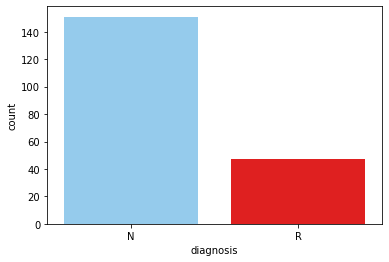

In [9]:
sns.countplot(data['diagnosis'], palette =('lightskyblue','red'))

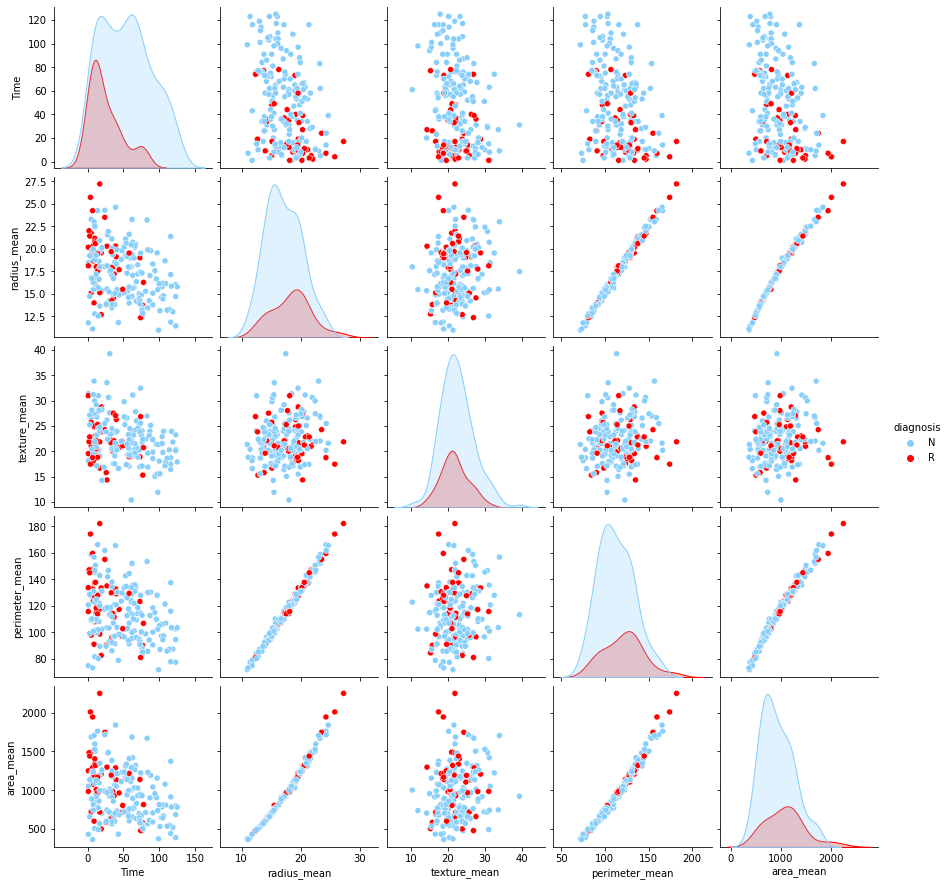

In [137]:
sns.pairplot(data.iloc[:,1:7],hue="diagnosis" , palette =('lightskyblue','red'))

### 1.3. Identify Missing values

In [174]:
data.plot(subplots=True, layout=(3,5))


plt.tight_layout()
plt.show

ValueError: Layout of 3x5 must be larger than required size 33

<Figure size 432x288 with 0 Axes>

In [162]:
null_feat = pd.DataFrame(len(data['id']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'blue',
        line=dict(color='lightblue',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

""""""#check for missing lymph node
missing = data.loc[(data["Lymph_node_status"]     =="?")]
                   
missing


    

id diagnosis  Time  radius_mean  texture_mean  perimeter_mean  \
6    844359         N    60        18.98         19.61          124.40   
28   854253         N    12        16.74         21.59          110.10   
85   877500         N    72        14.45         20.22           94.49   
196  947204         R     3        21.42         22.84          145.00   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  ...  \
6       1112.0          0.09087            0.1237          0.1213  ...   
28       869.5          0.09610            0.1336          0.1348  ...   
85       642.7          0.09872            0.1206          0.1180  ...   
196     1440.0          0.10700            0.1939          0.2380  ...   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
6              152.6      1593.0            0.1144             0.3371   
28             133.5      1229.0            0.1563             0.3835   
85             117.9      1044.0            0.1552             0.4056   
196            198.3      2375.0            0.1498             0.4379   

     concavity_worst  concave points_worst  symmetry_worst  \
6             0.2990                0.1922          0.2726   
28            0.5409                0.1813          0.4863   
85            0.4967                0.1838          0.4753   
196           0.5411                0.2215          0.2832   

     fractal_dimension_worst  tumor_size  Lymph_node_status  
6                    0.09581         1.5                  ?  
28                   0.08633         1.5                  ?  
85                   0.10130         1.5                  ?  
196                  0.08981         3.0                  ?  

[4 rows x 35 columns]


### Exploratory Data Analysis (EDA)


### 1.4. Reassign target and replace missing features



In [143]:
#All features are complete, only Lymph node status’ is missing in 4 cases, probably an error in the dataset, we drop it in below
# Drop useless variables
#data.drop(['id',], 1, inplace=True)

# Reassign target
data.diagnosis.replace(to_replace = dict(R = 1, N = 0), inplace = True)

#Lymph node status’ is missing in 4 cases 3 non-recur and 1 recur i am replacing ? with 9999
data.replace('?', -0, inplace = False)



TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [127]:
data.corr() 

diagnosis      Time  radius_mean  texture_mean  \
diagnosis                 1.000000 -0.351326     0.174124     -0.064295   
Time                     -0.351326  1.000000    -0.344722     -0.264671   
radius_mean               0.174124 -0.344722     1.000000      0.143456   
texture_mean             -0.064295 -0.264671     0.143456      1.000000   
perimeter_mean            0.176486 -0.346080     0.995933      0.142033   
area_mean                 0.189893 -0.344031     0.992855      0.140440   
smoothness_mean           0.020778  0.164793    -0.158239     -0.192262   
compactness_mean          0.000798  0.010000     0.159017     -0.039803   
concavity_mean            0.054893 -0.139475     0.469518      0.037165   
concave points_mean       0.118224 -0.171841     0.664010      0.006687   
symmetry_mean            -0.099777  0.177311    -0.051610     -0.165166   
fractal_dimension_mean   -0.112352  0.269992    -0.416674     -0.145572   
radius_se                 0.132512 -0.214543     0.602035      0.059168   
texture_se               -0.076212 -0.230477     0.079693      0.382533   
perimeter_se              0.141633 -0.231621     0.588927      0.075025   
area_se                   0.151826 -0.244159     0.710586      0.068517   
smoothness_se            -0.052213  0.019775    -0.036419      0.027119   
compactness_se           -0.009537 -0.002386     0.023647      0.063988   
concavity_se             -0.060379 -0.108648     0.154254      0.071920   
concave points_se        -0.065570 -0.140754     0.224771      0.010470   
symmetry_se              -0.044325  0.011156     0.019146     -0.094843   
fractal_dimension_se     -0.042751  0.099203    -0.072618     -0.020673   
radius_worst              0.233225 -0.265115     0.924183      0.123028   
texture_worst            -0.051134 -0.171125    -0.039439      0.862050   
perimeter_worst           0.231998 -0.280596     0.915053      0.123674   
area_worst                0.235310 -0.253930     0.891489      0.117467   
smoothness_worst          0.038520  0.212769    -0.372894     -0.113308   
compactness_worst        -0.020067  0.120516    -0.150712     -0.006467   
concavity_worst           0.017621  0.009546     0.038952      0.013635   
concave points_worst      0.074345 -0.026541     0.357869     -0.069921   
symmetry_worst           -0.074731  0.247678    -0.232142     -0.186850   
fractal_dimension_worst  -0.055170  0.288715    -0.414340     -0.085847   
tumor_size                0.177273 -0.133355     0.172102      0.027073   

                         perimeter_mean  area_mean  smoothness_mean  \
diagnosis                      0.176486   0.189893         0.020778   
Time                          -0.346080  -0.344031         0.164793   
radius_mean                    0.995933   0.992855        -0.158239   
texture_mean                   0.142033   0.140440        -0.192262   
perimeter_mean                 1.000000   0.990699        -0.102912   
area_mean                      0.990699   1.000000        -0.141470   
smoothness_mean               -0.102912  -0.141470         1.000000   
compactness_mean               0.236721   0.163176         0.666559   
concavity_mean                 0.533194   0.475862         0.623867   
concave points_mean            0.712766   0.667530         0.545734   
symmetry_mean                 -0.006512  -0.060785         0.540761   
fractal_dimension_mean        -0.353560  -0.397733         0.744890   
radius_se                      0.612708   0.623019         0.094728   
texture_se                     0.092256   0.084288         0.153848   
perimeter_se                   0.609964   0.609887         0.099518   
area_se                        0.718581   0.740830         0.037955   
smoothness_se                 -0.011788  -0.032969         0.344678   
compactness_se                 0.080725   0.020395         0.372393   
concavity_se                   0.202027   0.144443         0.375011   
concave points_se              0.254473   0.213582    

<AxesSubplot:>

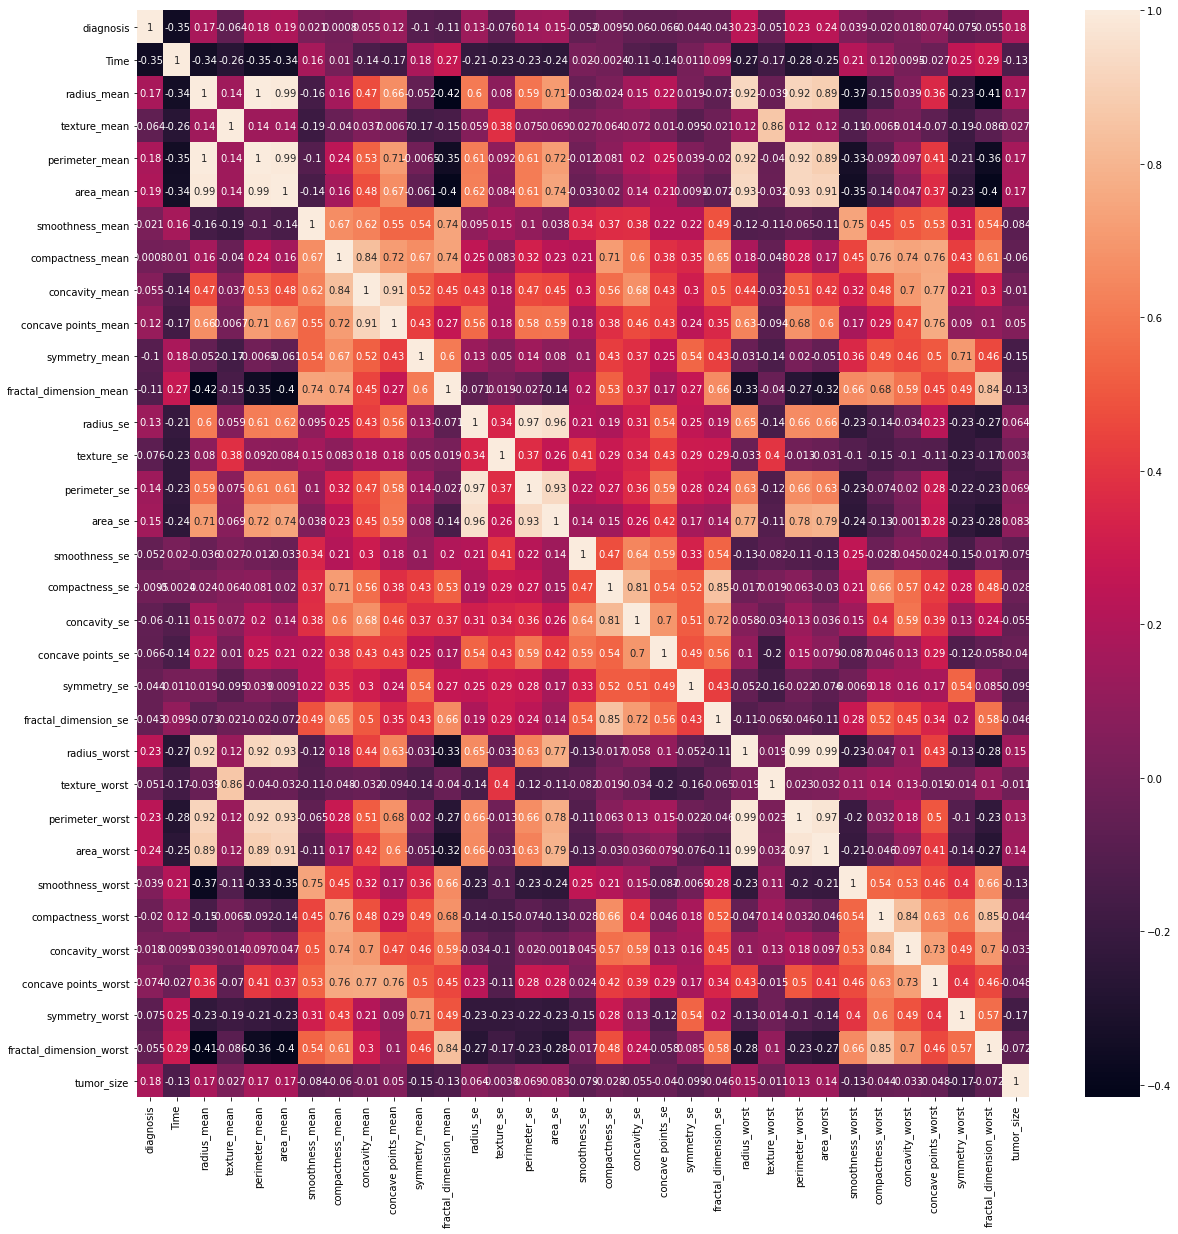

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), annot = True)

### 2.2. Target distribution (number and %)

In [15]:

# 2 datasets
R = data[(data['diagnosis'] == 1)]
N = data[(data['diagnosis'] == 0)]

In [16]:
#------------COUNT-----------------------
trace = go.Bar(x = (len(R), len(N)), y = ['Reccurent', 'Non_recurrent'], orientation = 'h', opacity = 0.8, marker=dict(
        color=[ 'red', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of diagnosis variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [17]:
#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['Non_Reccurent', 'Recurrent'], values = data['diagnosis'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue', 'red'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  ' percentage Distribution of diagnosis variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

### 2.3. Features distribution (hue = diagnosis)

In [18]:

def plot_distribution(data_select, size_bin) :  
    tmp1 = R[data_select]
    tmp2 = N[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Reccurent', 'Non_recurrent']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')


#### Bellow, you can remove the '#' to show all features distribution (except the first line)

In [19]:

#plot distribution 'mean'
plot_distribution('radius_mean', .5)
plot_distribution('texture_mean', .5)
plot_distribution('perimeter_mean', 5)
plot_distribution('area_mean', 10)
#plot_distribution('smoothness_mean', .5)
#plot_distribution('compactness_mean' .5)
#plot_distribution('concavity_mean' .5)
#plot_distribution('concave points_mean' .5)
#plot_distribution('symmetry_mean' .5)
#plot_distribution('fractal_dimension_mean' .5)
#plot distribution 'se'
plot_distribution('radius_se', .1)
plot_distribution('texture_se', .1)
plot_distribution('perimeter_se', .5)
plot_distribution('area_se', 5)
#plot_distribution('smoothness_se', .5)
#plot_distribution('compactness_se', .5)
#plot_distribution('concavity_se', .5)
#plot_distribution('concave points_se', .5)
#plot_distribution('symmetry_se', .5)
#plot_distribution('fractal_dimension_se', .5)
#plot distribution 'worst'
plot_distribution('radius_worst', .5)
plot_distribution('texture_worst', .5)
plot_distribution('perimeter_worst', 5)
plot_distribution('area_worst', 10)
#plot_distribution('smoothness_worst', .5)
#plot_distribution('compactness_worst', .5)
#plot_distribution('concavity_worst', .5)
#plot_distribution('concave points_worst', .5)
#plot_distribution('symmetry_worst', .5)
#plot_distribution('fractal_dimension_worst', .5)

### 2.4. Correlation matrix

In [20]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)
#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   xgap = 2,
                   ygap = 2,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)


### 2.5. Positive correlated features
#### Let's check the correlation between few features by pair

In [23]:

def plot_feat1_feat2(feat1, feat2) :  
    trace0 = go.Scatter(
        x = R[feat1],
        y = R[feat2],
        name = 'Recurrent',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = N[feat1],
        y = N[feat2],
        name = 'Non-Recurrent',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)
plot_feat1_feat2('perimeter_mean','radius_worst')
plot_feat1_feat2('area_mean','radius_worst')
plot_feat1_feat2('texture_mean','texture_worst')
plot_feat1_feat2('area_worst','radius_worst')

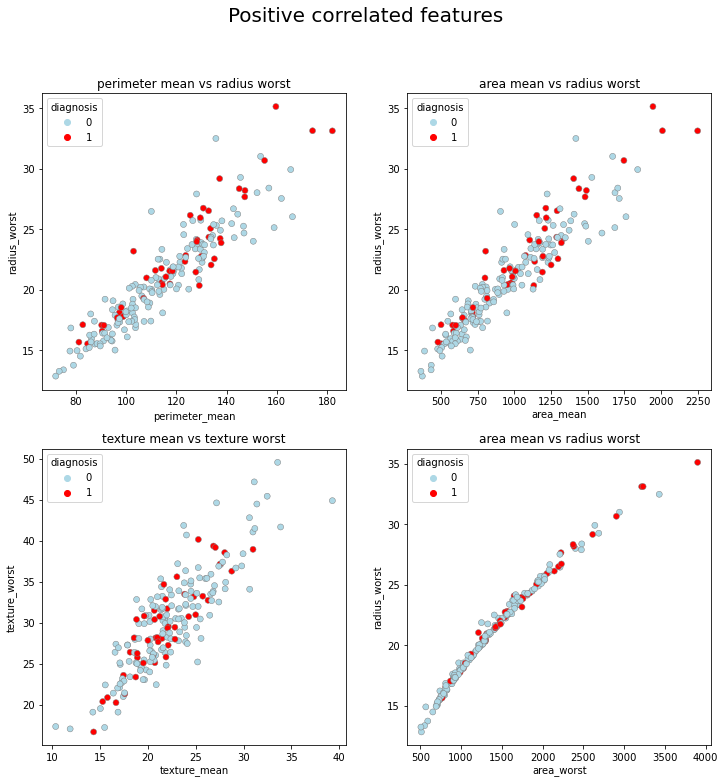

In [24]:
#seaborn version : 

palette ={0 : 'lightblue', 1 : 'red'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['perimeter_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette = palette, edgecolor=edgecolor)
plt.title('perimeter mean vs radius worst')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['texture_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs texture worst')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['area_worst'], y = data['radius_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs radius worst')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()


### 2.6. Uncorrelated features

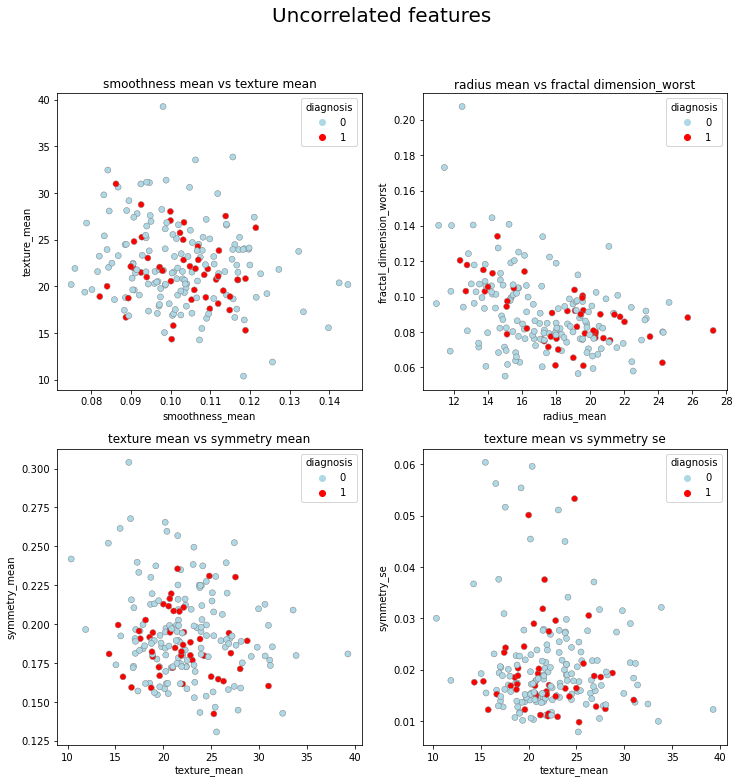

In [25]:
plot_feat1_feat2('smoothness_mean','texture_mean')
plot_feat1_feat2('radius_mean','fractal_dimension_worst')
plot_feat1_feat2('texture_mean','symmetry_mean')
plot_feat1_feat2('texture_mean','symmetry_se')
# seaborn version : 
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['smoothness_mean'], y = data['texture_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs texture mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_worst'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension_worst')
plt.subplot(223)
ax3 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry mean')
plt.subplot(224)
ax4 = sns.scatterplot(x = data['texture_mean'], y = data['symmetry_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('texture mean vs symmetry se')

fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

### 2.7. Negative correlated features

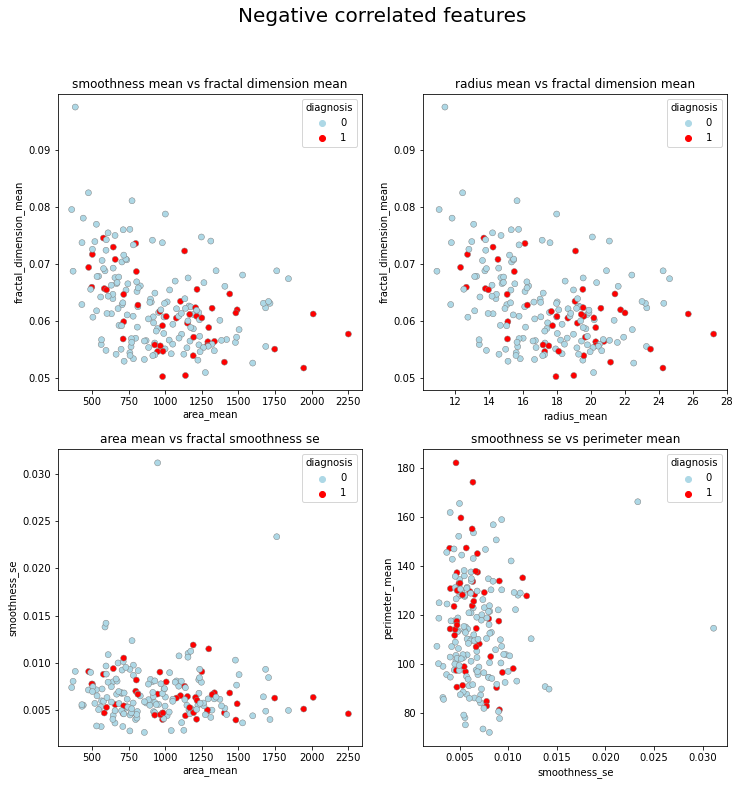

In [26]:
plot_feat1_feat2('area_mean','fractal_dimension_mean')
plot_feat1_feat2('radius_mean','fractal_dimension_mean')
plot_feat1_feat2('area_mean','smoothness_se')
plot_feat1_feat2('smoothness_se','perimeter_mean')
# seaborn version
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['area_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness mean vs fractal dimension mean')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['radius_mean'], y = data['fractal_dimension_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('radius mean vs fractal dimension mean')
plt.subplot(223)
ax2 = sns.scatterplot(x = data['area_mean'], y = data['smoothness_se'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('area mean vs fractal smoothness se')
plt.subplot(224)
ax2 = sns.scatterplot(x = data['smoothness_se'], y = data['perimeter_mean'], hue = "diagnosis",
                    data = data, palette =palette, edgecolor=edgecolor)
plt.title('smoothness se vs perimeter mean')

fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

In [ ]:
# generate a scatter plot matrix with the "mean columns"

cols = ['diagnosis',
        'Time',
        'radius_mean',
        'texture_mean',
        'perimeter_mean',
        'area_mean',
        'smoothness_mean',
        'compactness_mean',
        'concavity_mean',
        'concave points_mean',
        'symmetry_mean',
        'fractal_dimension_mean']

sns.pairplot(data=data[cols], hue ='diagnosis', palette ='rocket')
#ns.pairplot(BC_data.iloc[:,1:7],hue="diagnosis")

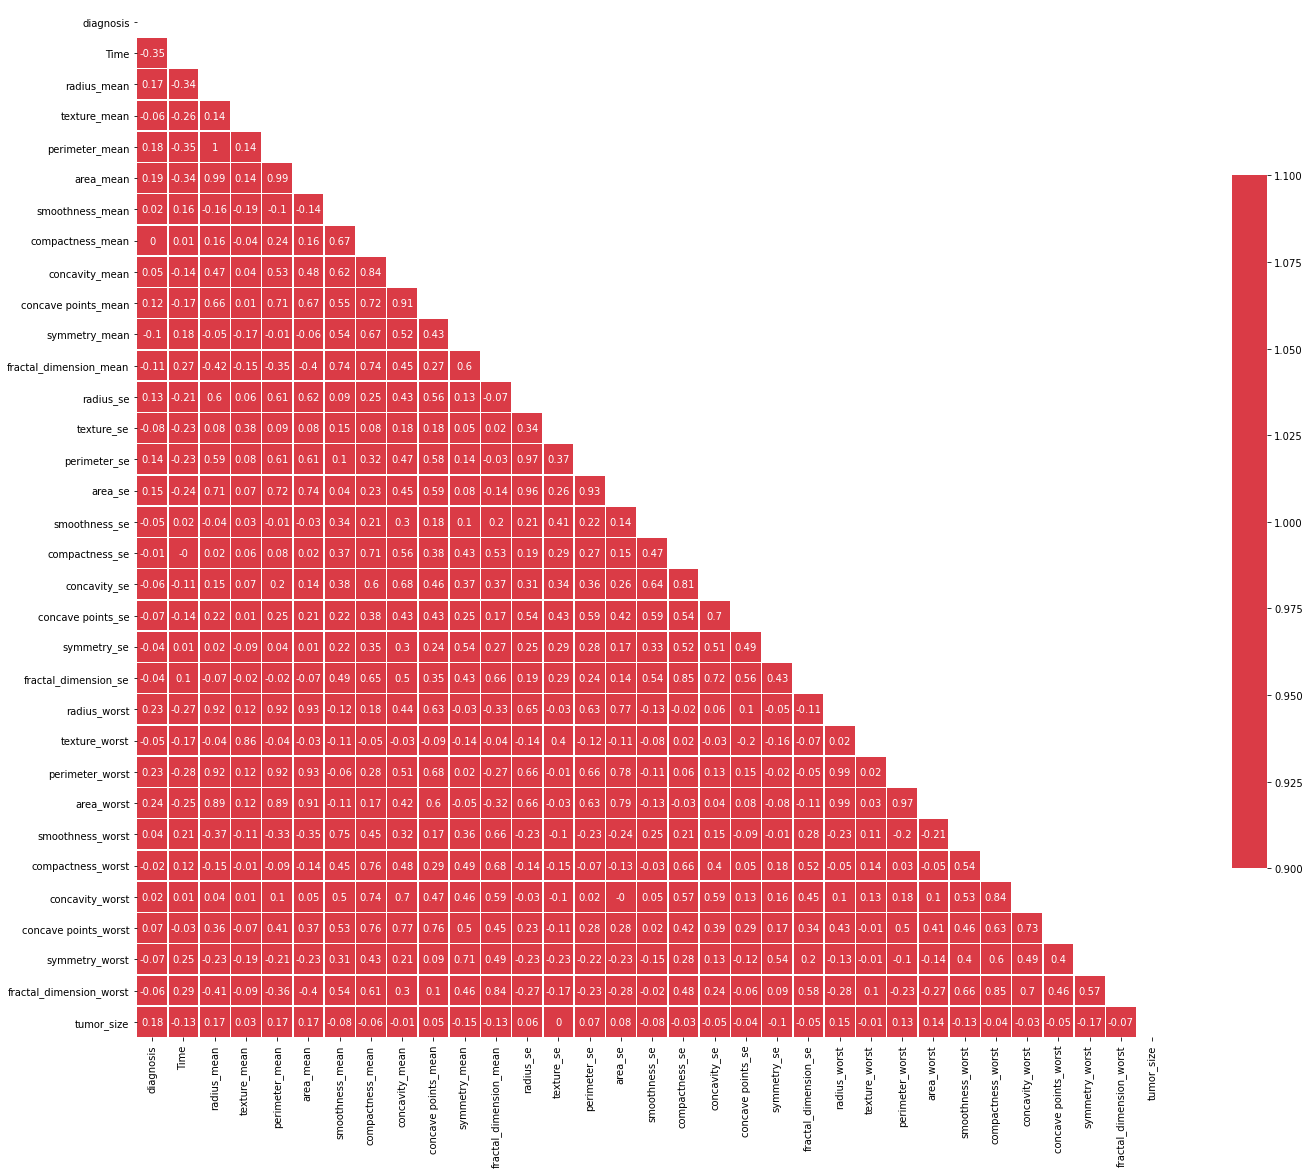

In [27]:
# Generate and visualise the correlation matrix
corr = data.corr().round(2)

#mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# set figure size
f, ax = plt.subplots(figsize =(20,20))

# Define custom colormap
cmap =sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heat nmap
sns.heatmap(corr, mask=mask,cmap=cmap, vmin=1, vmax=1, center=0,
           square=True, linewidth=.5, cbar_kws={"shrink": .5}, annot = True)

plt.tight_layout()

In [28]:

# first, drop all "worst" columns
cols = ['radius_worst', 
        'texture_worst', 
        'perimeter_worst', 
        'area_worst', 
        'smoothness_worst', 
        'compactness_worst', 
        'concavity_worst',
        'concave points_worst', 
        'symmetry_worst', 
        'fractal_dimension_worst']
data = data.drop(cols, axis=1)

# then, drop all columns related to the "perimeter" and "area" attributes
cols = ['perimeter_mean',
        'perimeter_se', 
        'area_mean', 
        'area_se']
data = data.drop(cols, axis=1)

# lastly, drop all columns related to the "concavity" and "concave points" attributes
cols = ['concavity_mean',
        'concavity_se', 
        'concave points_mean', 
        'concave points_se']
data = data.drop(cols, axis=1)

# verify remaining columns
data.columns

Index(['diagnosis', 'Time', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se', 'tumor_size',
       'Lymph_node_status'],
      dtype='object')

<AxesSubplot:>

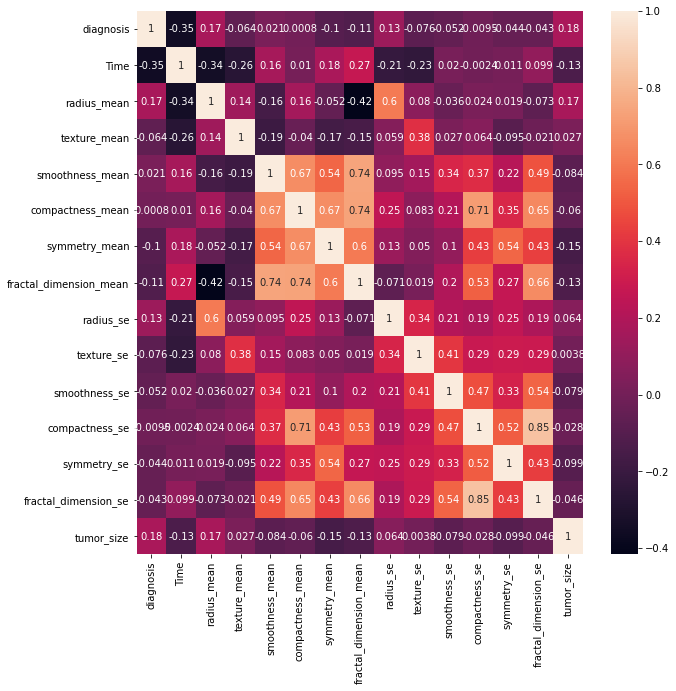

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot = True)

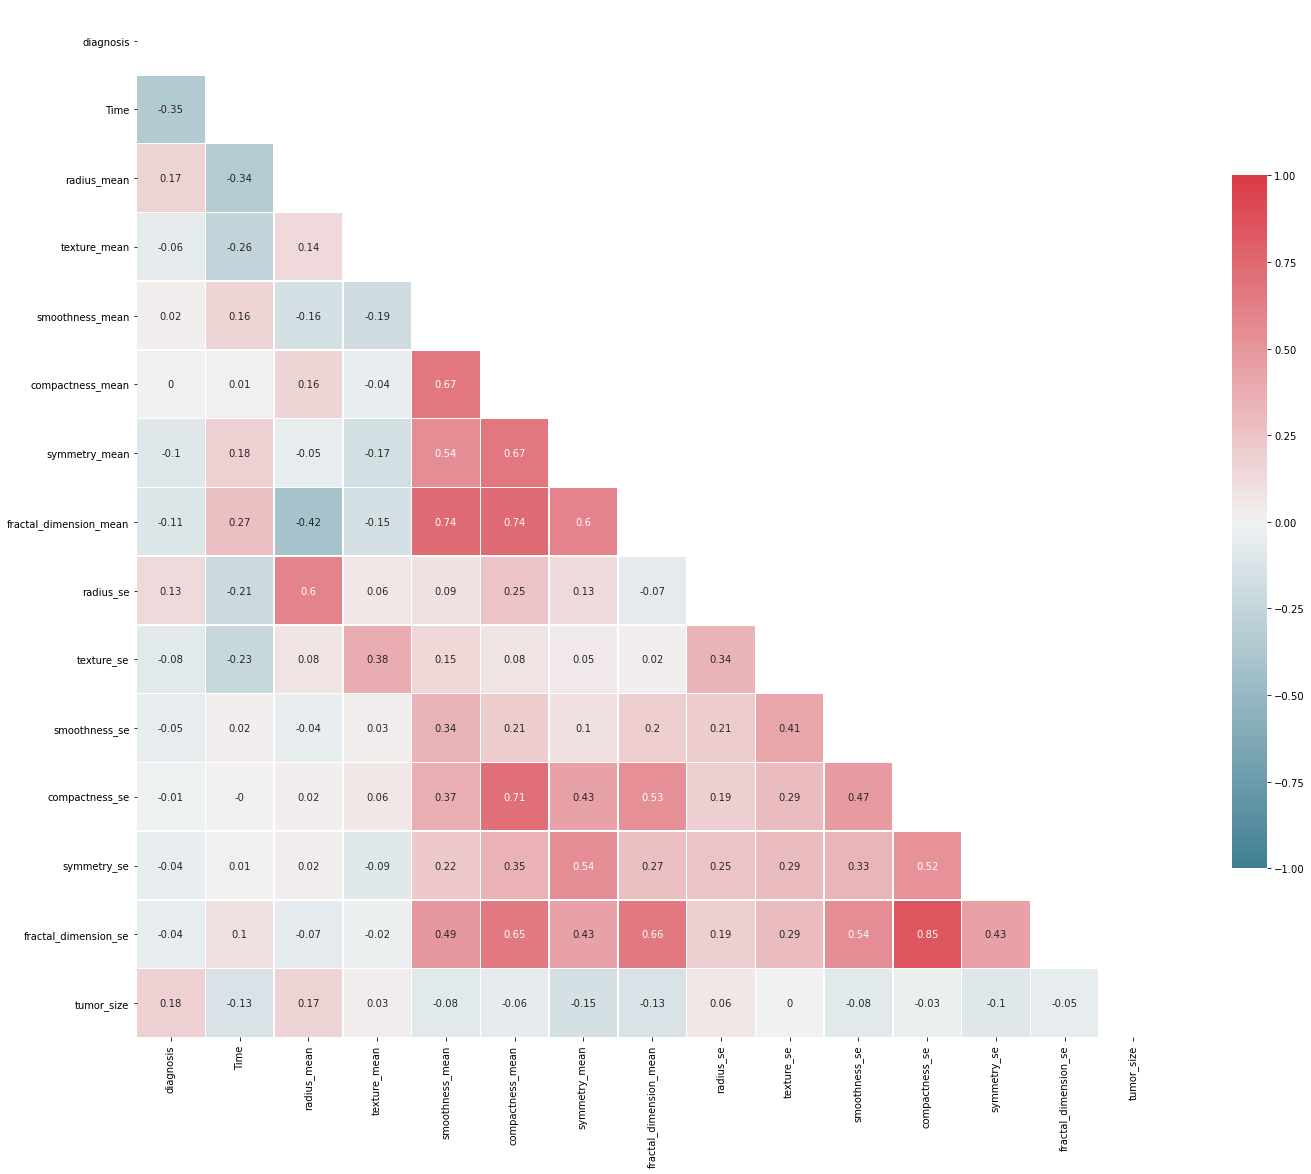

In [30]:
# Draw the heatmap again, with the new correlation matrix
corr = data.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()






### 4. Define functions
This part is essential to measure the performance of a model : roc, cross validation, learning curve ...

4.1. Confusion matrix and show metrics
The confusion matrix, also known as the error matrix, allows visualization of the performance of an algorithm :

true positive (TP) : Recurrent tumour correctly identified as recurent
true negative (TN) : Non Recurrent tumour correctly identified as Non Recurrent
false positive (FP) : Non Recurrent tumour incorrectly identified as Recurrent
false negative (FN) : recurrent tumour incorrectly identified as Non Recurrent
Metrics :

Accuracy : (TP +TN) / (TP + TN + FP +FN)
Precision : TP / (TP + FP)
Recall : TP / (TP + FN)

In [31]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [32]:
# Show metrics 
def show_metrics(cm):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy    =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision   =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall      =     {:.3f}'.format(tp/(tp+fn)))
    print('specificity =     {:.3f}'.format(tn/(tn+fp)))
    print('F1_score    =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))
    

### 4.2. Precision – Recall curve
The precision-recall curve shows the tradeoff between precision and recall for different threshold

In [33]:
# Precision-recall curve
def plot_precision_recall(cm):
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

### 4.3. ROC curve
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.


In [34]:
# ROC curve
def plot_roc(cm):
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([1,0],[1,0], 'k--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

    

### 4.4. Learning curve
The Learning curve determines cross-validated training and test scores.

In [35]:
# Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt

### 4.5. Cross validation metrics
Cross-validation is a technique to evaluate predictive models by partitioning the original sample into a training set to train the model, and a test set to evaluate it.


In [36]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 10, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))
        
        
        


In [ ]:
""""
#cross validate each model algorithm
results = []
names = []
for name, model in models:
    #If not statified, shuffle is vital given data is ordered by labels.
    kfold = KFold(n_splits=10, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_best_features_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))"""  
    

### 5. Prepare dataset
#### 5.1. Define (X, y)


In [ ]:
"""#y = diagnosis (target)
#X = features (radius_mean, area_se, ...)
# Def X and Y

X = list(data.columns[1:10])
y = np.array(data.diagnosis.tolist())

data = data.drop('diagnosis', 1)
X = np.array(data.to_numpy())
#X = np.array(data.as_matrix())"""


In [39]:
X = np.array(data.drop(['diagnosis'], 1))
y = np.array(data['diagnosis'])


In [40]:
print(X)
print(y)

[[31 18.02 27.6 ... 0.0034950000000000003 5.0 '5']
 [61 17.99 10.38 ... 0.006193 3.0 '2']
 [116 21.37 17.44 ... 0.005039 2.5 '0']
 ...
 [12 17.17 29.19 ... 0.001377 3.7 '0']
 [3 21.42 22.84 ... 0.003979 3.0 -9999]
 [6 16.7 28.13 ... 0.0036060000000000003 3.5 '0']]
[0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1
 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0]


### 5.3. Train test split
[reference link to train test split](https://scikit-learn.org/stable/glossary.html#term-random_state)
##### Random state = Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls . Popular integer random seeds are 0 and 42. 0 and 42
##### Test size = If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.
##### Train size =  represent the proportion of the dataset to include in the train split. If int, represents the absolute number of train samples. If None, the value is automatically set to the complement of the test size.

In [41]:

# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

### 5.2. Standard scaler (X)
Why do you need to standardize your data ? For example, a variable that ranges between 0 and 100 will outweigh a variable that ranges between 0 and 1. Using these variables without standardization in effect gives the variable with the larger range a bigger weight in the analysis


In [42]:
# Normalization

#from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)




### 5.3. Synthetic minority sampling technique (SMOTE)
#### This helps to deal with imbalanced dataset

In [43]:
# pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy = 'minority')
X_sm, y_sm = smote.fit_resample(X_train,y_train)

#X_sm.value_counts()
#y_sm.value_counts()
print (y_sm)
print (X_sm)

[0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[-0.81389145 -1.25677574  0.53086565 ...  0.1431541  -0.41176642
   0.14186139]
 [-0.31516985 -1.05739169 -0.06081415 ...  1.01196524 -0.67131254
   0.14186139]
 [-0.0218042   0.04565234 -0.38797827 ...  0.44481088  3.22187931
   0.14682772]
 ...
 [ 0.36130224 -1.10122933  0.3901418  ...  0.67774724  1.13135535
   0.14757589]
 [ 0.64099601  0.51041922 -0.7544818  ... -0.65730939  0.31648047
   0.15209028]
 [-1.07879039  0.36293172 -1.11162591 ... -0.26436003 -0.51250655
   0.1418649 ]]


<AxesSubplot:title={'center':'Class distribution after appying SMOTE'}, xlabel='Diagnosis'>

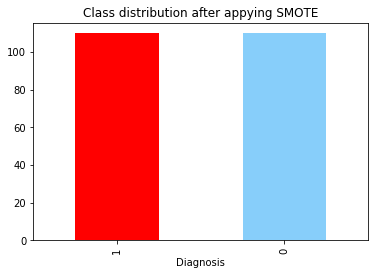

In [44]:
#------------COUNT-----------------------
pd.Series(y_sm).value_counts().plot(kind='bar', title='Class distribution after appying SMOTE', xlabel='Diagnosis', color =('red','lightskyblue'))



### 6. Predictive model 1: Logistic Regression
#### 6.1. Logistic Regression and GridSearch CV to optimise hyperparameters (accuracy)

In [45]:
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)


Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for using this model is {'C': 0.001, 'penalty': 'l2'}


In [46]:
#Log with best hyperparameters
"""CV_log_clf_sm = LogisticRegression(C = best_parameters['C'], 
                                penalty = best_parameters['penalty'], 
                                random_state = random_state)"""

CV_log_clf =  LogisticRegression(C = 1, 
                                penalty = 'l2', 
                                random_state = random_state)

CV_log_clf.fit(X_train, y_train)
y_pred1 = CV_log_clf.predict(X_test)
y_score = CV_log_clf.decision_function(X_test)



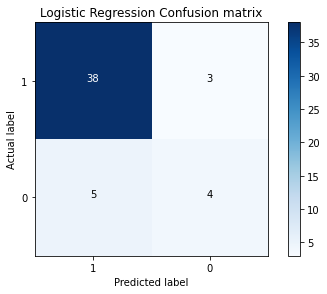

Accuracy    =     0.840
Precision   =     0.571
Recall      =     0.444
specificity =     0.927
F1_score    =     0.500
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        41
           1       0.57      0.44      0.50         9

    accuracy                           0.84        50
   macro avg       0.73      0.69      0.70        50
weighted avg       0.83      0.84      0.83        50



In [47]:
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred1)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='Logistic Regression Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

### Logistic Regression with the best hyperparameters (accuracy) vs smote

In [48]:
#Log with best hyperparameters and smote

CV_log_clf_sm = LogisticRegression(C = 1, 
                                penalty = 'l2', 
                                random_state = random_state)

CV_log_clf_sm.fit(X_sm, y_sm)
y_pred1_sm = CV_log_clf_sm.predict(X_test)
y_score_sm = CV_log_clf_sm.decision_function(X_test)


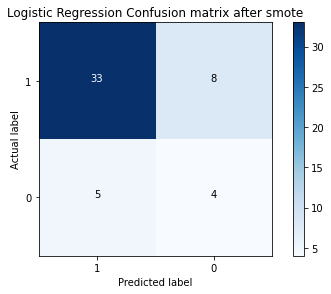

Accuracy    =     0.740
Precision   =     0.333
Recall      =     0.444
specificity =     0.805
F1_score    =     0.381
              precision    recall  f1-score   support

           0       0.87      0.80      0.84        41
           1       0.33      0.44      0.38         9

    accuracy                           0.74        50
   macro avg       0.60      0.62      0.61        50
weighted avg       0.77      0.74      0.75        50



In [49]:
# Confusion maxtrix & metrics
cm_sm = confusion_matrix(y_test, y_pred1_sm)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm_sm, 
                      classes=class_names, 
                      title='Logistic Regression Confusion matrix after smote')
plt.savefig('6')
plt.show()

show_metrics(cm_sm)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1_sm))

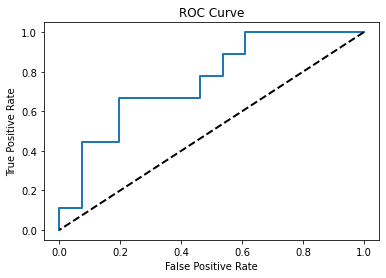

In [50]:

# ROC curve for loguistuics regression
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(cm)



### 6.3. Compare learning curves and cross validation scores

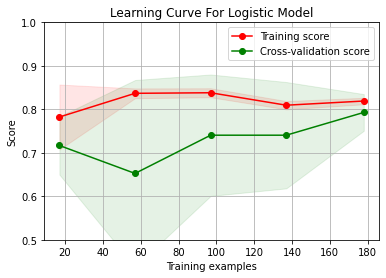

In [51]:
#Learning curve Log with best hyperpara
plot_learning_curve(CV_log_clf, 'Learning Curve For Logistic Model', X, y, (0.5,1.0), 10)
plt.savefig('7')
plt.show()


### 6. Predictive model 2 :K- nearest Neighbour
#### 6.1.trying to obtauin the best value for k (accuracy)

In [52]:
training_accuracy = [] 
test_accuracy = []
#try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

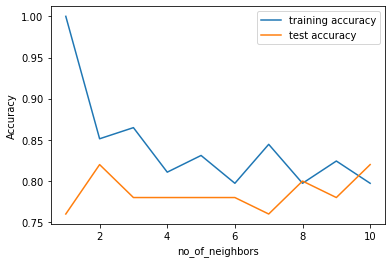

In [53]:
plt.plot(neighbors_settings, training_accuracy, label = "training accuracy")
plt.plot(neighbors_settings, test_accuracy, label = "test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("no_of_neighbors")
plt.legend()

#### I checked the best value of k= 3, k=5, k=6 ) to check for the best value of k that will give the best accauracy

In [54]:
#### I checked the best value of k= 2, k=5, k=6 ) to check for the best value of k that will give the best accauracy

KNN_clf = KNeighborsClassifier(n_neighbors=6)
KNN_clf.fit(X_train,y_train)

y_pred2=KNN_clf.predict(X_test)
y_score_k = KNN_clf.score(X_test, y_test)




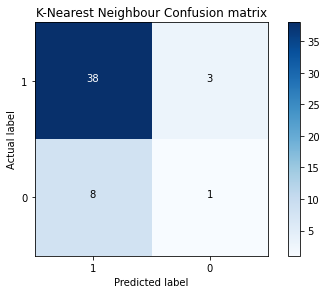

Accuracy    =     0.780
Precision   =     0.250
Recall      =     0.111
specificity =     0.927
F1_score    =     0.154
              precision    recall  f1-score   support

           0       0.83      0.93      0.87        41
           1       0.25      0.11      0.15         9

    accuracy                           0.78        50
   macro avg       0.54      0.52      0.51        50
weighted avg       0.72      0.78      0.74        50



In [55]:
# Confusion maxtrix & metrics before  smote
cm2 = confusion_matrix(y_test, y_pred2)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm2, 
                      classes=class_names, 
                      title='K-Nearest Neighbour Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm2)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2))

### KNN vs SMOTE

In [56]:
#### I checked the best value of k= 3, k=5, k=6 ) to check for the best value of k that will give the best accauracy

KNN_clf_sm = KNeighborsClassifier(n_neighbors=6)
KNN_clf_sm.fit(X_sm,y_sm)

y_pred2_sm=KNN_clf_sm.predict(X_test)
y_score_2_sm = KNN_clf.score(X_test, y_test)


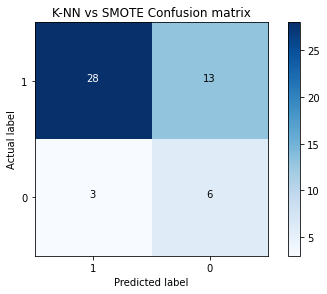

Accuracy    =     0.680
Precision   =     0.316
Recall      =     0.667
specificity =     0.683
F1_score    =     0.429
              precision    recall  f1-score   support

           0       0.90      0.68      0.78        41
           1       0.32      0.67      0.43         9

    accuracy                           0.68        50
   macro avg       0.61      0.67      0.60        50
weighted avg       0.80      0.68      0.71        50



In [57]:
# Confusion maxtrix & metrics before  smote
cm2_sm = confusion_matrix(y_test, y_pred2_sm)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm2_sm, 
                      classes=class_names, 
                      title='K-NN vs SMOTE Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm2_sm)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred2_sm))

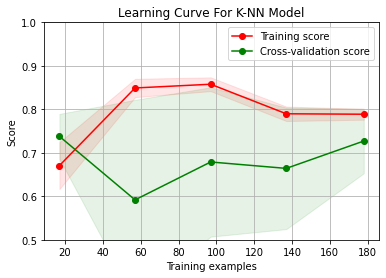

In [60]:
#Learning curve Log with best hyperpara
plot_learning_curve(KNN_clf, 'Learning Curve For K-NN Model', X, y, (0.5,1.0), 10)
plt.savefig('7')
plt.show()


### 6. Predictive model 3 :Naive Bayes
#### 6.1.Naive Bayes and GridSearch CV to optimise hyperparameters (accuracy)

In [61]:
#from sklearn.naive_bayes import MultinomialNB
#NB = MultinomialNB(alpha=1.0, class_prior=[0.25, 0.75], fit_prior=True)
NB=GaussianNB()


NB.fit(X_train,y_train)
y_pred3=NB.predict(X_test)



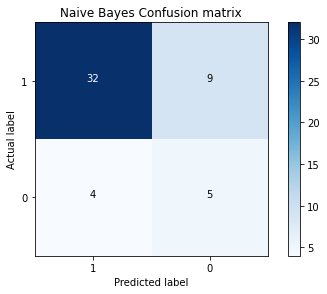

Accuracy    =     0.740
Precision   =     0.357
Recall      =     0.556
specificity =     0.780
F1_score    =     0.435
              precision    recall  f1-score   support

           0       0.89      0.78      0.83        41
           1       0.36      0.56      0.43         9

    accuracy                           0.74        50
   macro avg       0.62      0.67      0.63        50
weighted avg       0.79      0.74      0.76        50



In [62]:
# Confusion maxtrix & metrics
cm3 = confusion_matrix(y_test, y_pred3)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm3, 
                      classes=class_names, 
                      title='Naive Bayes Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm3)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred3))

In [63]:
##### Naive bayes vs SMOTE
NB_sm=GaussianNB()


NB_sm.fit(X_sm,y_sm)
y_pred3_sm=NB_sm.predict(X_test)



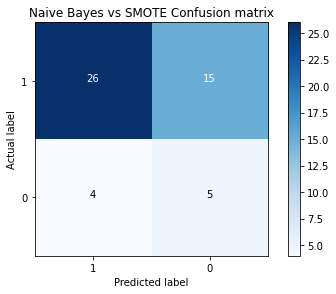

Accuracy    =     0.740
Precision   =     0.357
Recall      =     0.556
specificity =     0.780
F1_score    =     0.435
              precision    recall  f1-score   support

           0       0.87      0.63      0.73        41
           1       0.25      0.56      0.34         9

    accuracy                           0.62        50
   macro avg       0.56      0.59      0.54        50
weighted avg       0.76      0.62      0.66        50



In [64]:
# Confusion maxtrix & metrics
cm3_sm = confusion_matrix(y_test, y_pred3_sm)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm3_sm, 
                      classes=class_names, 
                      title='Naive Bayes vs SMOTE Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm3)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred3_sm))

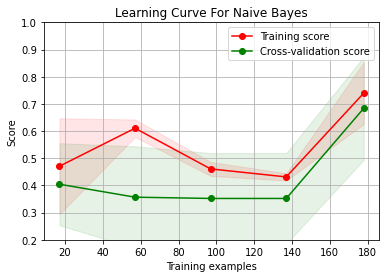

In [65]:
#Learning curve Log with best hyperpara
plot_learning_curve(NB, 'Learning Curve For Naive Bayes', X, y, (0.2,1.0), 10)
plt.savefig('7')
plt.show()


### 6. Predictive model 4 :Support Vector Machine
#### 6.1.Support Vector Machine and GridSearch CV to optimise hyperparameters (accuracy)
[Reference](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [66]:
## Trainimng the svm Model

SVM = SVC(kernel = 'linear', C = 1.0)
SVM.fit(X_train, y_train)
y_pred4= SVM.predict(X_test)


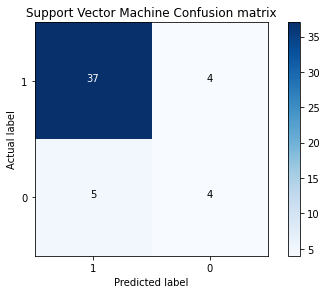

Accuracy    =     0.820
Precision   =     0.500
Recall      =     0.444
specificity =     0.902
F1_score    =     0.471
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        41
           1       0.50      0.44      0.47         9

    accuracy                           0.82        50
   macro avg       0.69      0.67      0.68        50
weighted avg       0.81      0.82      0.82        50



In [67]:
# Confusion maxtrix & metrics
cm4 = confusion_matrix(y_test, y_pred4)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm4, 
                      classes=class_names, 
                      title='Support Vector Machine Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm4)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred4))




In [68]:
## Trainimng the svm Model vs SMOTE

SVM_sm = SVC(kernel = 'linear')
SVM_sm.fit(X_sm, y_sm)
y_pred4_sm= SVM_sm.predict(X_test)

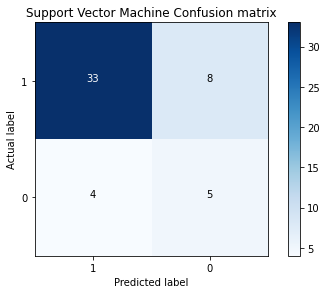

Accuracy    =     0.760
Precision   =     0.385
Recall      =     0.556
specificity =     0.805
F1_score    =     0.455
              precision    recall  f1-score   support

           0       0.89      0.80      0.85        41
           1       0.38      0.56      0.45         9

    accuracy                           0.76        50
   macro avg       0.64      0.68      0.65        50
weighted avg       0.80      0.76      0.78        50



In [69]:
# Confusion maxtrix & metrics vs SMOTE
cm4_sm = confusion_matrix(y_test, y_pred4_sm)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm4_sm, 
                      classes=class_names, 
                      title='Support Vector Machine Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm4_sm)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred4_sm))


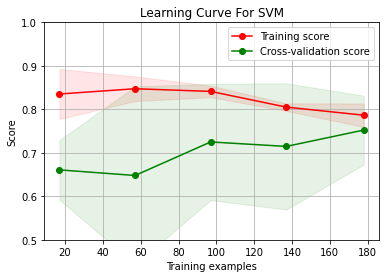

In [70]:
#Learning curve Log with best hyperpara
plot_learning_curve(SVM, 'Learning Curve For SVM', X, y, (0.5,1.0), 10)
plt.savefig('7')
plt.show()


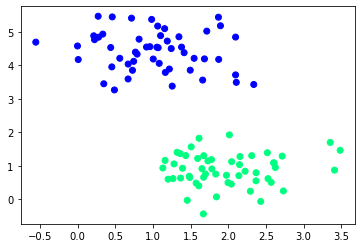

In [71]:
#Plot decision boundary
#from sklearn.datasets.sample_generator import make_blobs
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=125, centers=2, cluster_std =0.60, random_state =0)
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size = 20, random_state = 0)
plt.scatter(train_X[:, 0], train_X[:,1], c=train_y, cmap='winter')




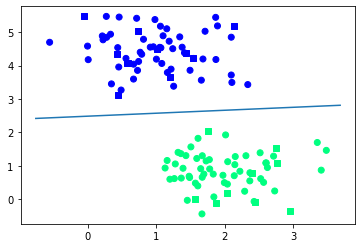

In [72]:
svc =SVC(kernel= 'linear')
svc.fit(train_X, train_y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap='winter')

ax = plt.gca()
xlim = ax.get_xlim()

ax.scatter(test_X[:, 0], test_X[:, 1], c=test_y, cmap='winter', marker='s')

w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - (svc.intercept_[0] / w[1])
plt.plot(xx, yy)
plt.show()

### CROSS VALIDATION SCORES OF THE 4 MODELS

##### kfold is a resampling technique that evaluate the machine learning
##### Cross-validation is a statistical method used to estimate the performance (or accuracy) of machine learning models. It is used to protect against overfitting 
###### in a predictive model, particularly in a case where the amount of data may be limited

In [101]:
models=[]

models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('LR', LogisticRegression()))
models.append(('SVM', SVC()))

In [74]:
# cross evaluate each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_train, y_train, cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.751905, (0.122640)
NB:, 0.656667, (0.110502)
lr:, 0.730952, (0.088557)
SVM:, 0.785238, (0.102319)


In [75]:
# cross evaluate each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_train, y_train, cv=kfold,scoring='precision')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.466667, (0.355903)
NB:, 0.365000, (0.209291)
lr:, 0.385000, (0.234811)
SVM:, 0.566667, (0.416333)


In [76]:
# cross evaluate each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_train, y_train, cv=kfold,scoring='recall')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.218333, (0.164899)
NB:, 0.428333, (0.221240)
lr:, 0.291667, (0.181391)
SVM:, 0.226667, (0.168358)


## Cross validation of the four models with smote

In [99]:
# cross evaluate each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_sm, y_sm, cv=kfold,scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.740909, (0.148059)
NB:, 0.677273, (0.102550)
lr:, 0.740909, (0.076196)
SVM:, 0.781818, (0.094912)


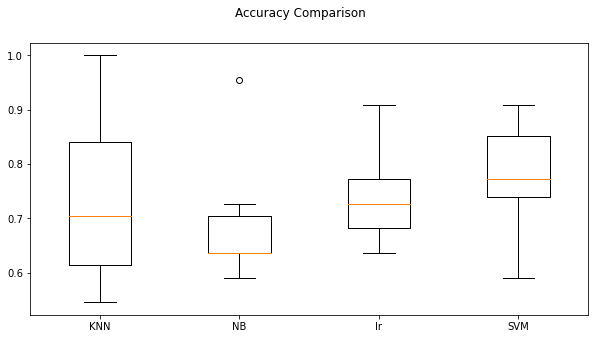

In [104]:
#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Accuracy Comparison (%)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


In [95]:
# cross evaluate each model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results_2 =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_sm, y_sm, cv=kfold,scoring='precision')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.618700, (0.262343)
NB:, 0.591432, (0.274658)
lr:, 0.667532, (0.252496)
SVM:, 0.720433, (0.210801)


In [96]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
results_3 =[]
names=[]
for name , model in models:
    kfold=KFold(n_splits=10,  shuffle = False)
    cv_results= cross_val_score(model, X_sm, y_sm, cv=kfold,scoring='recall')
    results.append(cv_results)
    names.append(name)
    
    msg= '%s:, %f, (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN:, 0.939755, (0.067006)
NB:, 0.735231, (0.161791)
lr:, 0.812554, (0.153656)
SVM:, 0.809380, (0.160204)


# PLOTTING ROC CURVE

To quantify this, we can calculate the AUC – area under the curve – which tells us how much of the plot is located under the curve.
The closer AUC is to 1, the better the model. A model with an AUC equal to 0.5 is no better than a model that makes random classifications.
The AUC for this logistic regression model turns out to be 0.5602. Since this is close to 0.5, this confirms that the model does a poor job of classifying data.

In [80]:
# ROC curve
#fpr, tpr, t = roc_curve(y_test, y_score)
#plot_roc()

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
Predictions= KNN_clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, Predictions)
auc = metrics.roc_auc_score(y_test,Predictions)


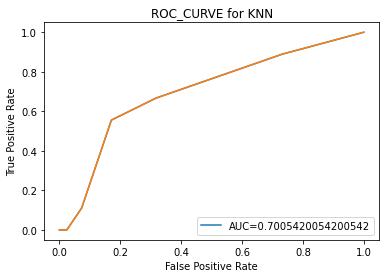

In [81]:
Predictions= KNN_clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, Predictions)
auc = metrics.roc_auc_score(y_test,Predictions)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr,tpr)
plt.title('ROC_CURVE for KNN')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [82]:
fpr

array([0.        , 0.02439024, 0.07317073, 0.17073171, 0.31707317,
       0.73170732, 1.        ])

In [83]:
tpr

array([0.        , 0.        , 0.11111111, 0.55555556, 0.66666667,
       0.88888889, 1.        ])

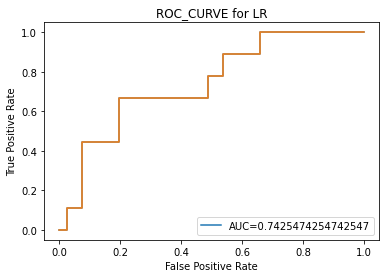

In [84]:
Prediction1=CV_log_clf_sm.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, Prediction1)
auc = metrics.roc_auc_score(y_test,Prediction1)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr,tpr)
plt.title('ROC_CURVE for LR')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [85]:
fpr

array([0.        , 0.02439024, 0.02439024, 0.07317073, 0.07317073,
       0.19512195, 0.19512195, 0.48780488, 0.48780488, 0.53658537,
       0.53658537, 0.65853659, 0.65853659, 1.        ])

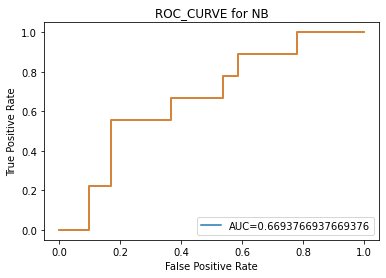

In [86]:
Prediction2= NB.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test, Prediction2)
auc = metrics.roc_auc_score(y_test,Prediction2)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr,tpr)
plt.title('ROC_CURVE for NB')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

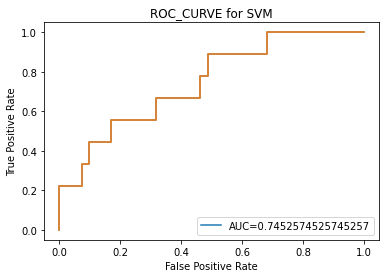

In [87]:
Prediction3=SVM.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, Prediction3)
auc = metrics.roc_auc_score(y_test,Prediction3)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr,tpr)
plt.title('ROC_CURVE for SVM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

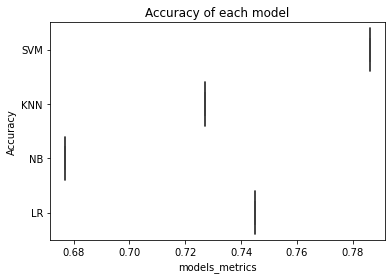

In [92]:
   
models_metrics =  ['SVM','KNN','NB','LR']
Accuracy = [0.786,0.727,0.677,0.745]
fig = sns.boxplot(x=Accuracy, y=models_metrics)



plt.title('Accuracy of each model')
plt.ylabel('Accuracy')
plt.xlabel('models_metrics')
plt.rcParams['figure.figsize']=(10,5)
plt.savefig('Ac curacy.png')
plt.show(fig)


In [88]:
df2 = pd.DataFrame(data=df, columns = ['summary_groundTruth_wordCount','summary_Luhn_wordCount','summary_LSA_wordCount','summary_TextRank_wordCount', 'summary_LexRank_wordCount','summary_BERT_wordCount', 'summary_Pegasus_wordCount'])
df2 = df2.rename(columns={'summary_groundTruth_wordCount': 'Ground Truth', 'summary_Luhn_wordCount': 'Luhn','summary_LSA_wordCount': 'LSA', 'summary_TextRank_wordCount':'TextRank', 'summary_LexRank_wordCount': 'LexRank', 'summary_BERT_wordCount': 'BERT', 'summary_Pegasus_wordCount': 'PEGASUS'})
fig = sns.boxplot(x="variable", y="value", data=pd.melt(df2))



plt.title('Word Count vs Summary')
plt.ylabel('Word Count')
plt.xlabel('Summary')
plt.rcParams['figure.figsize']=(10,5)
plt.savefig('word_count_200.png')
plt.show(fig)


#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

   
models_metrics =  ['SVM','KNN','NB','LR']
Accuracy = [0.786,0.727,0.677,0.745]

New_Colors = ['gold', 'lightgreen', 'coral', 'lightblue']
plt.bar(models_metrics, Accuracy, color = New_Colors , width = 0.4 )
plt.ylim([0.2,1])
plt.ylim([0.0,1.05])
plt.title('Accuracy Measure',  fontsize=14)
plt.xlabel('' )
plt.ylabel('')
plt.show()



NameError: name 'SGDClassifier' is not defined

In [ ]:
# Threshold
thresholds_adj = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize = (15,15))

j = 1
for i in thresholds_adj:
    y_score = CV_log_clf.predict_proba(X_test)[:,1] > i
    
    
    plt.subplot(3,3,j)
    j += 1
    
    cm = confusion_matrix(y_test, y_score)
    
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]

    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    
    class_names = [1,0]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 



### 6.4. Select threshold for a recall = 100% (all RECURRENT tumors detected)
For this study, the most important is to detect all malignants tumours.

### 6.5. Predicting with recall = 100%


In [ ]:
# Recall = 1.
y_score = CV_log_clf.predict_proba(X_test)[:,1] > 0.1
cm = confusion_matrix(y_test, y_score)
class_names = [0,1]
show_metrics(cm)



#### 7.1. Logistic Regression and GridSearch CV to optimise hyperparameters (recall)

In [ ]:
# Find the best parameters (recall)
log2_clf = LogisticRegression(random_state = random_state)
param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            }

CV_log2_clf = GridSearchCV(estimator = log2_clf, param_grid = param_grid , scoring = 'recall', verbose = 1, n_jobs = -1)
CV_log2_clf.fit(X_train, y_train)

best_parameters = CV_log2_clf.best_params_
print('The best parameters for using this model is', best_parameters)


### LR with the best hyperparameters (recall)

In [ ]:
CV_log2_clf = LogisticRegression(C = best_parameters['C'], 
                                 penalty = best_parameters['penalty'], 
                                 random_state = random_state)


CV_log2_clf.fit(X_train, y_train)

y_pred5 = CV_log2_clf.predict(X_test)
y_score2 = CV_log2_clf.decision_function(X_test)

In [ ]:

# Confusion maxtrix & metrics
cm5 = confusion_matrix(y_test, y_pred5)
class_names = [1,0]
plt.figure()
plot_confusion_matrix(cm5, 
                      classes=class_names, 
                      title='Support Vector Machine Confusion matrix')
plt.savefig('6')
plt.show()

show_metrics(cm5)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred5))

In [ ]:
# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score2)
plot_roc()


In [ ]:

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_score2)
plot_precision_recall()



### 7.5. Models performance plot (accuracy, precision, recall)

In [176]:

fx = sns.boxplot(x='Accuracy', y='models_metrics', data=data, hue='diagnosis', palette='Set2')

ValueError: Could not interpret input 'Accuracy'

In [ ]:


#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

   
models_metrics =  ['SVM','KNN','NB','LR']
Accuracy = [0.786,0.727,0.677,0.745]

New_Colors = ['gold', 'lightgreen', 'coral', 'lightblue']
plt.bar(models_metrics, Accuracy, color = New_Colors , width = 0.4 )
plt.ylim([0.2,1])
plt.ylim([0.0,1.05])
plt.title('Accuracy Measure',  fontsize=14)
plt.xlabel('' )
plt.ylabel('')
plt.show()




In [ ]:
   
models_metrics =  ['SVM','KNN','NB','LR']
Precision = [0.755,0.607,0.589,0.675]

New_Colors = ['gold', 'lightgreen', 'coral', 'lightblue']
plt.bar(models_metrics, Precision, color = New_Colors , width = 0.5 )
plt.ylim([0.2,1])
plt.ylim([0.0,1.05])
plt.title('Precision Measure',  fontsize=14)
plt.xlabel('' )
plt.ylabel('')
plt.show()




In [ ]:
   
models_metrics =  ['SVM','KNN','NB','LR']
Recall = [ 0.756, 0.904,0.696,0.802]

New_Colors = ['gold', 'green', 'coral', 'blue']
plt.bar(models_metrics, Recall, color = New_Colors, width = 0.4  )
plt.ylim([0.2,1])
plt.ylim([0.0,1.05])
plt.title('Precision Measure',  fontsize=14)
plt.xlabel('' )
plt.ylabel('')
plt.show()



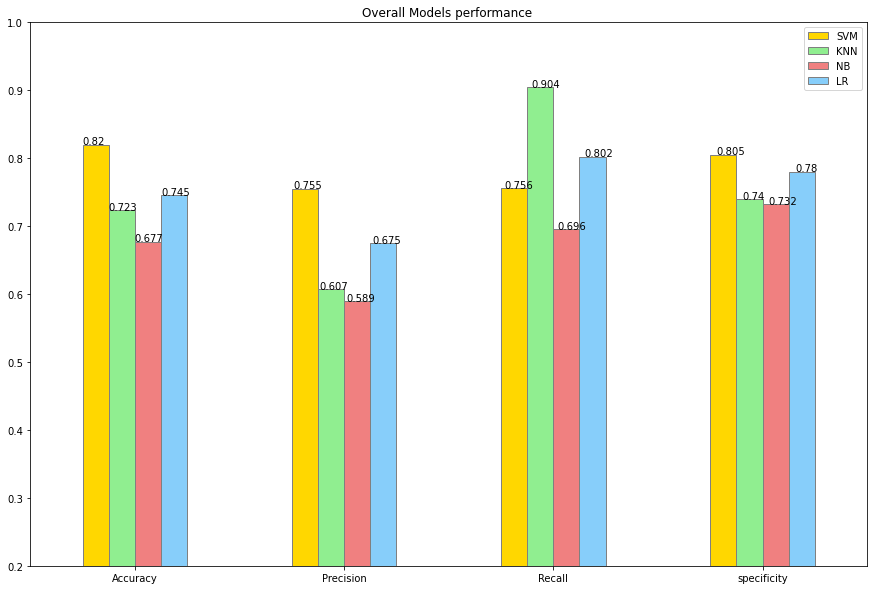

In [105]:

models_metrics = {'SVM': [0.820, 0.755, 0.756, 0.805], 
                 'KNN': [0.723, 0.607, 0.904,0.740],
                 'NB' : [0.677,0.589,0.696,0.732],
                 'LR' : [0.745,0.675,0.802,0.780]
                }
df = pd.DataFrame(data = models_metrics)
df.rename(index={0:'Accuracy',1:'Precision', 2: 'Recall' , 3: 'specificity'}, 
                 inplace=True)
ax = df.plot(kind='bar', figsize = (15,10), ylim = (0.20, 1), 
        color = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue'],
        rot = 0, title ='Overall Models performance ',
        edgecolor = 'grey', alpha = 1.0)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.0005))
plt.show()

#Thank you all ! Merci à tous ! :)

In [ ]:

  # Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause



C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(
        C=C, penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 K-Nearest Neighbour": KNeighborsClassifier(n_neighbors=n_neighbors, multi_class="multinomial", max_iter=10000
    ),
    "L3 NaiveBayes": NB(
        C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "L4 Linear SVC": SVC(kernel="linear", C=C, probability=True, random_state=0),
    "GPC": GaussianProcessClassifier(kernel),
}

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=0.2, top=0.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(
            probas[:, k].reshape((100, 100)), extent=(3, 9, 1, 5), origin="lower"
        )
        plt.xticks(())
        plt.yticks(())
        idx = y_pred == k
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker="o", c="w", edgecolor="k")

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation="horizontal")

plt.show()
    

In [ ]:
#boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
df2 = pd.DataFrame(data=df, columns = ['summary_groundTruth_wordCount','summary_Luhn_wordCount','summary_LSA_wordCount','summary_TextRank_wordCount', 'summary_LexRank_wordCount','summary_BERT_wordCount', 'summary_Pegasus_wordCount'])
df2 = df2.rename(columns={'summary_groundTruth_wordCount': 'Ground Truth', 'summary_Luhn_wordCount': 'Luhn','summary_LSA_wordCount': 'LSA', 'summary_TextRank_wordCount':'TextRank', 'summary_LexRank_wordCount': 'LexRank', 'summary_BERT_wordCount': 'BERT', 'summary_Pegasus_wordCount': 'PEGASUS'})
fig = sns.boxplot(x="variable", y="value", data=pd.melt(df2))



plt.title('Word Count vs Summary')
plt.ylabel('Word Count')
plt.xlabel('Summary')
plt.rcParams['figure.figsize']=(10,5)
plt.savefig('word_count_200.png')
plt.show(fig)



# df